# 4.2 Assistants


The Assistants API makes it possible to create AI assistants within applications. An Assistant has instructions and can use models, tools and files to answer the user's questions. The Assistants API currently supports three types of tools: Code Interpreter, File Search and Function Calling.


#

# 4.2.1 Assistant

In this example, an Assistant is created with the purpose of being a personal maths tutor.

Initially, an Assistant is created, which represents an entity that can be configured to respond to a user's messages using various parameters such as a , `name`, `instructions` and `model`.

In [42]:
from openai import OpenAI
from runners.standard_run import std_run
from runners.streaming_run import streaming_run


client = OpenAI()

assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    model="gpt-3.5-turbo",
)

Next, a Thread is created that represents a conversation between a user and one or more Assistants. A Thread can be created when a user (or their AI application) starts a conversation with their Assistant.

In [2]:
thread = client.beta.threads.create()

A message is added to the Thread, the content of the messages that users or applications create is added as objects to the Message Thread. 

In [3]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I need to solve the equation: 4a - 13 = 7."
)

When the user has added all of the necessary information/messages to the thread you must run the thread to provide them with results.

You can run a thread using its id as well as the assistant's id, like this:

In [4]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    #model = "gpt-3.5-turbo" # By default the model defined in the assistant will be used. You can, however, overwrite it here.
    instructions = "Please address the user as SISTCA student." # This parameter is optional
)

During its lifecycle, a run can have multiple states:

![image.png](https://cdn.openai.com/API/docs/images/diagram-run-statuses-v2.png)
[https://platform.openai.com/docs/assistants/how-it-works/runs-and-run-steps]

Therefore, we must check for its completion.

In [6]:
if run.status == 'completed': 
    messages = client.beta.threads.messages.list(
    thread_id=thread.id
    )
    print(messages)
else:
    print(run.status)

queued


The result is then returned by printing the messages returned by the run.

In [8]:
messages = client.beta.threads.messages.list(thread_id = thread.id)
print(messages.data[0].content[0].text.value)

Sure, SISTCA student! To solve the equation 4a - 13 = 7, you need to isolate the variable a. 

First, add 13 to both sides of the equation to get rid of the constant term on the left side:
4a - 13 + 13 = 7 + 13
4a = 20

Next, divide both sides by 4 to solve for a:
4a/4 = 20/4
a = 5

So, the solution to the equation 4a - 13 = 7 is a = 5.


In order to yield any results, an assistant's thread must be run. This is to say that whenever you're working with the assistant functionality you must have a runner function. 

Due to the fact that we will be exploring other types of assistants, and as a way of not repeating this code multiple times, we will export as the following function:

In [ ]:
def std_run (thread_id, assistant_id, client):
    run = client.beta.threads.runs.create_and_poll(
        thread_id = thread_id,
        assistant_id = assistant_id,
        instructions = "Please address the user as SISTCA student."
    )   

    if run.status == 'completed': 
        messages = client.beta.threads.messages.list(thread_id = thread_id)
        print(messages.data[0].content[0].text.value)
    else:
        print(run.status)

If you have used ChatGPT before you may have noticed that the output is not returned all at once, like it is here, but rather gradually, in real time.

We can achieve this same effect by using a different type of runner, the streaming run.


In this run, the streaming_run function is defined, which is responsible for starting the streaming with the assistant. 
Within this, the 'EventHandler' class is defined, which is inherited from AssistantEventHandler. 
This class contains the methods responsible for dealing with the different events that occur during streaming: 

* `on_text_created`: Called when a new text is created by the assistant. This prints 'assistant' to indicate that the assistant is responding.

* `on_text_delta`: Called for each text update. This prints the part of the text that was generated (delta.value).

* `on_tool_call_created`: Called when the wizard calls a tool. This prints the type of tool call (tool_call.type).

* `on_tool_call_delta`:  Called for tool call updates, specifically for the code_interpreter. This prints the code_interpreter input and any outputs, especially logs.


Finally, the API client's create_and_stream method is used to start streaming, passing the EventHandler as the event handler.


* `thread_id`: and`assistant_id` are the required identifiers.
* `instructions` defines specific instructions for the assistant, in this case asking it to address the user as a SISTCA student.
* `event_handler` is the instance of the EventHandler class.

The `with` block ensures that streaming continues until it is finished (stream.until_done()).

In [10]:
from typing_extensions import override
from openai import AssistantEventHandler


def streaming_run (thread_id, assistant_id, client):

    # First, we create a EventHandler class to define
    # how we want to handle the events in the response stream.
    
    class EventHandler(AssistantEventHandler):    
        @override
        def on_text_created(self, text) -> None:
            print(f"\nassistant > ", end="", flush=True)
            
        @override
        def on_text_delta(self, delta, snapshot):
            print(delta.value, end="", flush=True)
            
        def on_tool_call_created(self, tool_call):
            print(f"\nassistant > {tool_call.type}\n", flush=True)
        
        def on_tool_call_delta(self, delta, snapshot):
            if delta.type == 'code_interpreter':
                if delta.code_interpreter.input:
                    print(delta.code_interpreter.input, end="", flush=True)
            if delta.code_interpreter.outputs:
                print(f"\n\noutput >", flush=True)
                for output in delta.code_interpreter.outputs:
                    if output.type == "logs":
                        print(f"\n{output.logs}", flush=True)


    # Then, we use the `create_and_stream` SDK helper 
    # with the `EventHandler` class to create the Run 
    # and stream the response.
    
    with client.beta.threads.runs.stream(
        thread_id=thread_id,
        assistant_id=assistant_id,
        instructions="Please address the user as SISTCA student.",
        event_handler=EventHandler(),
    ) as stream:
        stream.until_done()

In [11]:
print(streaming_run(thread.id, assistant.id, client))


assistant > I hope this explanation was helpful! If you have any more equations or need further assistance, feel free to ask.None


# 4.2.2 Function Calling

Function Calling is one of Assistants API's tools, which in simple terms, invokes predefined functions in order to respond to a certain prompt. As you will verify in just a moment, in this tutorial we asked our weather assistant to give us the maximum and minimum temperatures and rain probability in a certain location.  

By using functions we allow the assistant to call additional methods as it sees fit. Assistants will analyse the user's message and decide if there is a function that can be used to answer the request and, if so, a request to call that function will be made to the runner.

For instance, in this case we want to make it so that when asking for weather data for a Portuguese city or region the data should come from [IPMA](https://www.ipma.pt/pt/index.html).

By using [IPMA'S API](https://api.ipma.pt/) we can check the weather data for a specific location using it's ID.



We start by defining the functions the assistant may call, alongside their parameters.

In [43]:
assistant = client.beta.assistants.create(
    instructions="You are a weather bot. Use the provided functions to answer questions.",
    model="gpt-3.5-turbo",
    tools=[
        {
            "type": "function",
            "function": {
                "name": "get_weather_data",
                "description": "Get the current weather forecast for the specified location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "City or region for which to get the weather forecast",
                        }
                    },
                    "required": ["location"]
                }
            }
        }
    ]
)


Then, we must define actual functions to fetch the weather data.

To get weather data for a city or region we must first know its global ID. We can do this be accessing the [list of identifiers](https://api.ipma.pt/open-data/distrits-islands.json) and extracting the `globalIdLocal` for the desired city (`location_name`).


By visiting the [list of identifiers endpoint](https://api.ipma.pt/open-data/distrits-islands.json), this json is returned:
```
{
    "owner": "IPMA",
    "country": "PT",
    "data": [
        {
            "idRegiao": 1,
            "idAreaAviso": "AVR",
            "idConcelho": 5,
            "globalIdLocal": 1010500,
            "latitude": "40.6413",
            "idDistrito": 1,
            "local": "Aveiro",
            "longitude": "-8.6535"
        },
        {
            "idRegiao": 1,
            "idAreaAviso": "BJA",
            "idConcelho": 5,
            "globalIdLocal": 1020500,
            "latitude": "38.0200",
            "idDistrito": 2,
            "local": "Beja",
            "longitude": "-7.8700"
        },
    [...]    
```


Knowing the json structure, define a function to get the globalIdLocal for the matching city: 

In [19]:
import requests

def get_location_id(location_name):
    url = "https://api.ipma.pt/open-data/distrits-islands.json"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            for location in data["data"]:
                # Check if the location name matches the input by converting them to lower case, so that i.e. "Porto" == "porto"
                if location["local"].lower() == location_name.lower():
                    return str(location["globalIdLocal"])
            return None  # Location not found
        else:
            print("Failed to fetch data:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None

In [20]:
# Test the function:
location_id = get_location_id("Porto")
print(location_id)

1131200


The next function, `get_weather_data()`, uses the `location_id` returned by `get_location_id()` to access the actual weather data of the required location, which we then return.

In [21]:
def get_weather_data(location_id):
    url = f"https://api.ipma.pt/open-data/forecast/meteorology/cities/daily/{location_id}.json"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            forecast = data["data"][0]
            return forecast
        else:
            print("Failed to fetch data:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None

In [23]:
# Test the function:
weather_data = get_weather_data("1131200")
print(weather_data)

{'precipitaProb': '99.0', 'tMin': '11.5', 'tMax': '16.8', 'predWindDir': 'W', 'idWeatherType': 6, 'classWindSpeed': 2, 'longitude': '-8.6294', 'forecastDate': '2024-05-18', 'classPrecInt': 2, 'latitude': '41.1580'}


Having created the necessary functions we can now try running our assistant by creating a thread and adding a message requesting a weather forecast.

In [58]:
thread = client.beta.threads.create()

#Define the location name
location_name = "Porto"

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=f"How is the weather today in {location_name}?",
)

print(message.content[0].text.value + "\n")

How is the weather today in Porto?



Now, initiate a run to yield a response.

In [59]:
run = client.beta.threads.runs.create_and_poll(
        thread_id = thread.id,
        assistant_id = assistant.id
    )   

In [60]:
if run.status == 'completed': 
    messages = client.beta.threads.messages.list(
    thread_id=thread.id
    )
    print(messages)
else:
    print(run.status)

requires_action


This time the run status returns a different value - `required_action`. This likely means that the assistant called a function and is waiting for a response.

Let's check that:

In [61]:
# Check if a run is trying to call a tool and if so,  act accordingly
for tool in run.required_action.submit_tool_outputs.tool_calls:
    if tool.function.name == "get_weather_data":

        # let's start by checking the content of the tool call
        print(tool.function)

Function(arguments='{"location":"Porto"}', name='get_weather_data')


The assistant wants to call the `get_weather_data` tool using the value "Porto" as the location argument.

While the assistant is smart enough to realize that it should use the get_weather_data tool to answer the user's question it does not know how to proceed, because we never linked that tool with any of our two previously defined functions.

The set of instructions to be performed when an assistant calls a function are defined in the runner. Let's do that:

In [62]:
import json

# Check if a run is trying to call a tool and if so,  act accordingly
for tool in run.required_action.submit_tool_outputs.tool_calls:
    if tool.function.name == "get_weather_data":

        # First, call the get_location_id function to get the location ID for the location argument in the tool call
        location_id = get_location_id(json.loads(tool.function.arguments)["location"])

        # Now, knowing the location ID, we can call the get_weather_data function to get the weather data for the location
        forecast = get_weather_data(location_id)

Forecast returns the following json:

In [63]:
forecast

{'precipitaProb': '99.0',
 'tMin': '11.5',
 'tMax': '16.8',
 'predWindDir': 'W',
 'idWeatherType': 6,
 'classWindSpeed': 2,
 'longitude': '-8.6294',
 'forecastDate': '2024-05-18',
 'classPrecInt': 2,
 'latitude': '41.1580'}

To provide the user with relevant weather data we shall return the minimum and maximum temperature as well as the rain probability.

In [64]:
print(f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}")

Rain probability: 99.0, Max temperature: 11.5, Min temperature: 16.8


To output this data we first define an array in which to store the tool outputs. In this case we only have one single tool, but this would be especially useful if we were dealing with multiple tools.

In [65]:
# Create an array to store the tool outputs
tool_outputs = []

Finally, we submit the output of the `get_weather_data` function to the run by appending an "output" key to the output array.


In [66]:
tool_outputs.append({"tool_call_id": tool.id,
                    "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                    })

Having defined the tool outputs we must now add them to the runner so that our assistant can use them to answer our initial question.

In [67]:
if tool_outputs:
    try:
        run = client.beta.threads.runs.submit_tool_outputs_and_poll(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )
        print("Tool outputs submitted successfully.")
    except Exception as e:
        print("Failed to submit tool outputs:", e)
else:
    print("No tool outputs to submit.")

Tool outputs submitted successfully.


We then check for the run completion and display the output message:

In [68]:
if run.status == 'completed':
    messages = client.beta.threads.messages.list(thread_id=thread.id)
    print(messages.data[0].content[0].text.value)
else:
    print(run.status)

The weather in Porto today includes a high chance of rain with a probability of 99%. The maximum temperature is 16.8°C and the minimum temperature is 11.5°C.


The updated runner with the tool call handling code will look like this:

In [ ]:
def std_run (thread_id, assistant_id, client):
    run = client.beta.threads.runs.create_and_poll(
        thread_id = thread_id,
        assistant_id = assistant_id,
        instructions = "Please address the user as SISTCA student."
    )   

    if run.status == 'completed': 

        messages = client.beta.threads.messages.list(
            thread_id = thread_id
        )

        # This code acts upon the presence of image files when using code interpreter
        if messages.data[0].content[0].type == 'image_file':
            return(messages.data[0].content[0].image_file.file_id)
        else:
            print(run.status)

        return(messages.data[0].content[0].text.value)        
    
    # The following code is used to handle tool/function calls

    # Preparing tool outputs
    tool_outputs = []
    for tool in run.required_action.submit_tool_outputs.tool_calls:
        if tool.function.name == "get_weather_data":
            location_id = get_location_id(json.loads(tool.function.arguments)["location"])
            forecast = get_weather_data(location_id)
            tool_outputs.append({"tool_call_id": tool.id,
                                "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                                })

    # Submitting tool outputs and polling for completion status
    if tool_outputs:
        try:
            run = client.beta.threads.runs.submit_tool_outputs_and_poll(
                thread_id=thread_id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )
            print("Tool outputs submitted successfully.")
        except Exception as e:
            print("Failed to submit tool outputs:", e)
    else:
        print("No tool outputs to submit.")

    # Retrieving messages after tool output submission
    if run.status == 'completed':
        messages = client.beta.threads.messages.list(thread_id=thread_id)
        print(messages.data[0].content[0].text.value)
    else:
        print(run.status)

Using the same logic we can also stream the response in the runner. However, since function calling uses different events that can conflict we the previously defined ones, instead of updating the streaming_run function we will create a new one.

In [ ]:
def streaming_run_fc (thread_id, assistant_id, client):

    class EventHandler(AssistantEventHandler):
        @override
        def on_event(self, event):

            # Retrieve events that are denoted with 'requires_action'
            # since these will have our tool_calls
            
            if event.event == 'thread.run.requires_action':
                run_id = event.data.id  # Retrieve the run ID from the event data
                self.handle_requires_action(event.data, run_id)
    
        def handle_requires_action(self, data, run_id):
            tool_outputs = []
            
            for tool in data.required_action.submit_tool_outputs.tool_calls:
                if tool.function.name == "get_weather_data":
                    location_id = get_location_id(json.loads(tool.function.arguments)["location"])
                    forecast = get_weather_data(location_id)
                    tool_outputs.append({"tool_call_id": tool.id,
                                        "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                                        })
            
            # Submit all tool_outputs at the same time
            self.submit_tool_outputs(tool_outputs, run_id)
    
        def submit_tool_outputs(self, tool_outputs, run_id):
            # Use the submit_tool_outputs_stream helper
            with client.beta.threads.runs.submit_tool_outputs_stream(
                thread_id=self.current_run.thread_id,
                run_id=self.current_run.id,
                tool_outputs=tool_outputs,
                event_handler=EventHandler(),
            ) as stream:
                for text in stream.text_deltas:
                    print(text, end="", flush=True)
                print()
    
    
    with client.beta.threads.runs.stream(
        thread_id=thread_id,
        assistant_id=assistant_id,
        event_handler=EventHandler()
    ) as stream:
        stream.until_done()

# 4.2.3 Code Interpreter


The Assistant's Code Interpreter makes it possible for assistants to write and run python code to answer user questions and analyze files.

The Code Interpreter works similarly to the tools in the previous tutorial as it too is a tool.

In this tutorial we will attempt to portray Code Interpreter's usefulness for data analysis by providing it with a file containing the data of 100 customers of a ficticious organization.

In [83]:
file = client.files.create(
    file=open("customers-100.csv", "rb"),
    purpose='assistants'
)

To use code interpreter it must be passsed as a tool parameter of the assistant object. We will also be adding our previously defined file as a resource. 

In [85]:
assistant = client.beta.assistants.create(
    instructions="Your purpose is to analyze the provided documents and to provide answers based on them.",
    model="gpt-3.5-turbo",
    tools=[{"type": "code_interpreter"}],
    tool_resources={
        "code_interpreter": {
        "file_ids": [file.id]
        }
    }
)

Next, we create a thread and will try asking the assistant for the customer ID of Sheryl Baxter, the customer in the first row of the provided file. If it works, the value `DD37Cf93aecA6Dc` should be returned.

In [86]:
thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What is the customer Id for Sheryl Baxter?"
)

print(message.content[0].text.value + "\n")

What is the customer Id for Sheryl Baxter?



This time will simply call our previously defined runner instead of writing the runner code all over again.

In [72]:
print(std_run(thread.id, assistant.id, client))

completed
The Customer ID for Sheryl Baxter is DD37Cf93aecA6Dc.


It works! 

Now, for something more complex, let's ask the assistant to create a graph using the provided file.

In [87]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Create a graph of the number of customers per country."
)

print(message.content[0].text.value + "\n")

Create a graph of the number of customers per country.



This action should return a file with the attached graph. When an assistant return a file it is marked as an `image_file`. To access it we must get its id.

This can be achieved by checking for the presence of an `image_file` in the return messages of a completed run:

In [79]:
if run.status == 'completed': 

    messages = client.beta.threads.messages.list(
        thread_id = thread.id
    )

    # This code acts upon the presence of image files when using code interpreter
    if messages.data[0].content[0].type == 'image_file':
        print(messages.data[0].content[0].image_file.file_id)
    else:
        print(run.status)

file-q1eCoDXNKiExMyxgZcvH30qI


The updated runner with this code looks like this:

In [88]:
def std_run (thread_id, assistant_id, client):
    run = client.beta.threads.runs.create_and_poll(
        thread_id = thread_id,
        assistant_id = assistant_id,
        instructions = "Please address the user as SISTCA student."
    )   

    if run.status == 'completed': 

        messages = client.beta.threads.messages.list(
            thread_id = thread_id
        )

        # This code acts upon the presence of image files when using code interpreter
        if messages.data[0].content[0].type == 'image_file':
            return(messages.data[0].content[0].image_file.file_id)
        else:
            print(run.status)

        return(messages.data[0].content[0].text.value)        
    
    # The following code is used to handle tool/function calls

    # Preparing tool outputs
    tool_outputs = []
    for tool in run.required_action.submit_tool_outputs.tool_calls:
        if tool.function.name == "get_weather_data":
            location_id = get_location_id(json.loads(tool.function.arguments)["location"])
            forecast = get_weather_data(location_id)
            tool_outputs.append({"tool_call_id": tool.id,
                                "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                                })

    # Submitting tool outputs and polling for completion status
    if tool_outputs:
        try:
            run = client.beta.threads.runs.submit_tool_outputs_and_poll(
                thread_id=thread_id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )
            print("Tool outputs submitted successfully.")
        except Exception as e:
            print("Failed to submit tool outputs:", e)
    else:
        print("No tool outputs to submit.")

    # Retrieving messages after tool output submission
    if run.status == 'completed':
        messages = client.beta.threads.messages.list(thread_id=thread_id)
        print(messages.data[0].content[0].text.value)
    else:
        print(run.status)

Store the file ID:

In [89]:
file_id = std_run(thread.id, assistant.id, client)

To retrieve the file we must call the `files endpoint` using the `file_id`.

In [91]:
image_data = client.files.content(file_id=file_id)
image_data_bytes = image_data.read()

Save and display the result:

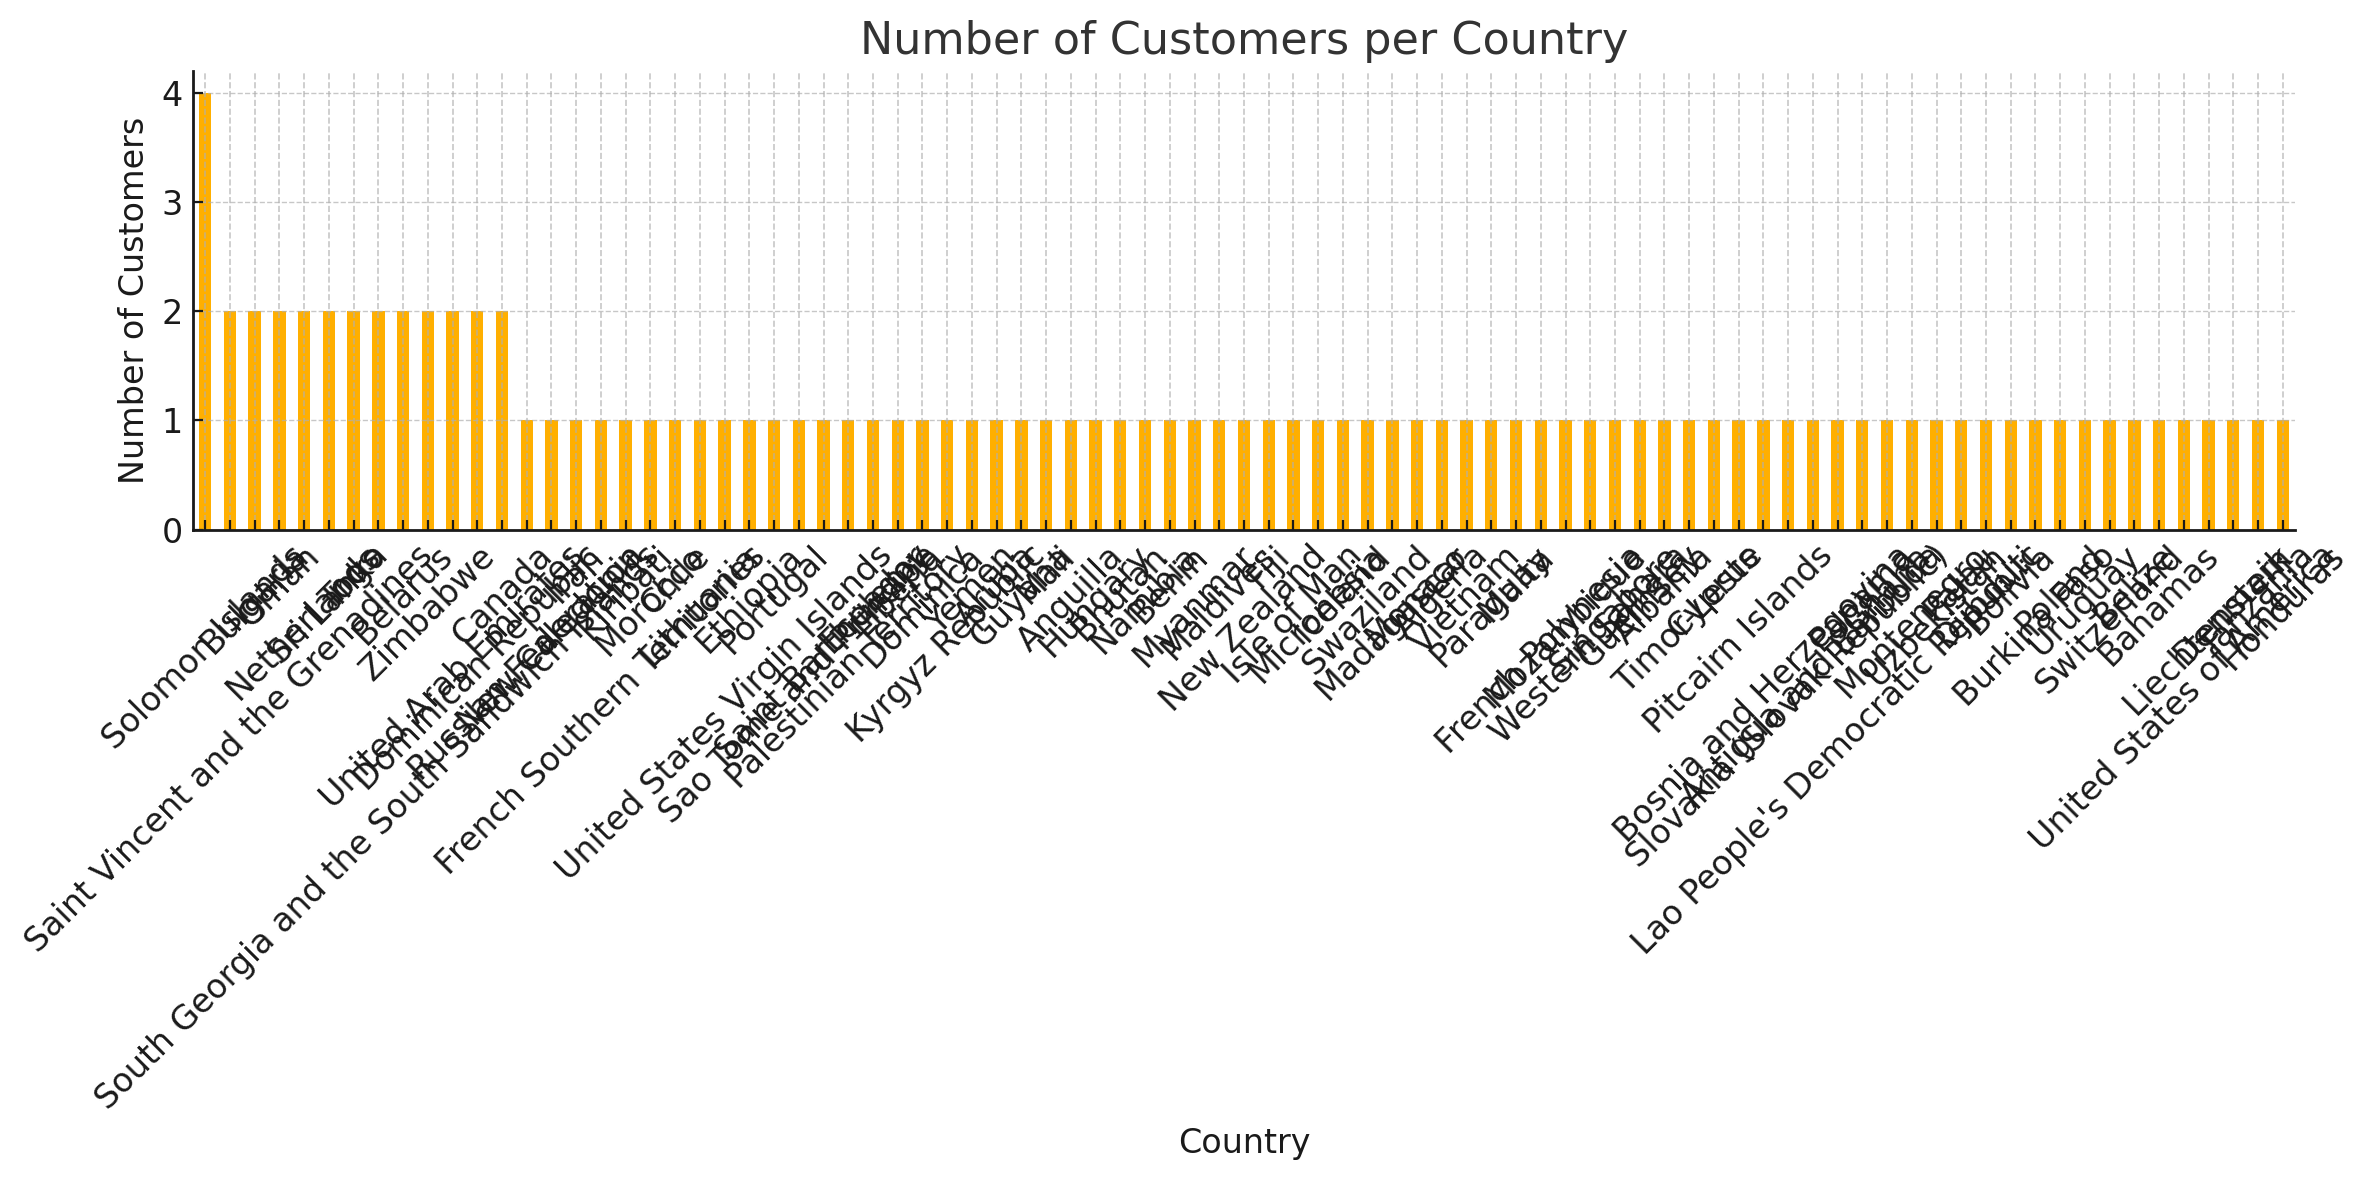

In [92]:
import IPython

image_name = "graph.png"

with open(image_name, "wb") as file:
    file.write(image_data_bytes)

IPython.display.Image(image_name)

# 4.2.4 File Search